In [1]:
from models import RBM

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [4]:
batch_size = 128 # batch size
n_epochs = 10 # number of epochs
lr = 0.01 # learning rate
n_hid = 100 # number of neurons in the hidden layer
n_vis = 28*28 # input size
k = 3 # The number of Gibbs sampling

In [4]:
batch_size=128
train_datasets = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)
test_datasets = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_datasets,
    batch_size=batch_size,
    shuffle=True
)

In [7]:
def neuron_fireing_vis(model, n_dataset, n_hid):
    """
    全データに対する隠れ層のニューロン発火行列を取得
    """
    vv1 = np.zeros((len(train_datasets), n_hid))

    for idx, (x, y) in enumerate(train_loader):
        x = x.view(-1, n_vis)
        vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().cpu().numpy() # [batch_size, n_hid]
    return vv1

In [8]:
def recon_ave_test_loss(model):
    total_loss = 0
    for (data, target) in test_loader:
        v = data.view(-1, n_vis)
        v_gibbs = model(v)
        total_loss += F.mse_loss(v, v_gibbs).item()
    
    return total_loss / len(test_loader)

In [59]:
model = RBM(n_vis=n_vis, n_hid=n_hid, k=k).cpu()
from tqdm import tqdm

loss_ = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.train()

recon_loss_func = F.mse_loss
recon_loss_ = []
neuron_fireings = []
neuron_fireings.append(neuron_fireing_vis(model=model, n_dataset=len(train_datasets), n_hid=n_hid))
with tqdm(range(n_epochs)) as t:
    for epoch in t:
        for (data, target) in train_loader:
            v = data.view(-1, n_vis)
            v_gibbs = model(v)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            recon_loss = recon_loss_func(v, v_gibbs)
            loss_.append(loss.item())
            recon_loss_.append(recon_loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t.set_description(f"loss={loss.item():.2}")
        neuron_fireings.append(neuron_fireing_vis(model=model, n_dataset=len(train_datasets), n_hid=n_hid))


loss=1.3e+02: 100%|█████████████████████████████████████| 10/10 [03:29<00:00, 21.00s/it]


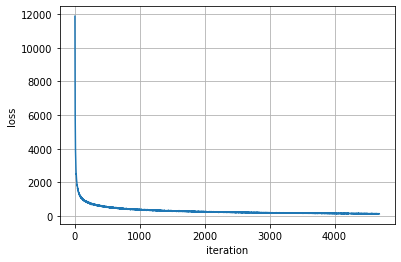

In [61]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.ylim(0, 300)
plt.grid()

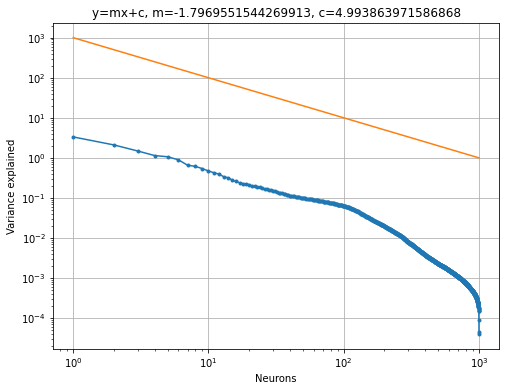

In [64]:
import sklearn
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(neuron_fireings[-1])

fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')
ax.plot(xx, 1000 * xx ** (-1.0))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
xx = np.log(xx)
yy = np.log(pca.explained_variance_)
m, c = np.linalg.lstsq(np.vstack([xx, np.ones(len(xx))]).T, yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.grid()

In [13]:
import json
import pickle
import datetime

def experiment(params):
    n_vis, n_hid, k, optim_method = params
    model = RBM(n_vis=n_vis, n_hid=n_hid, k=k).cpu()
    batch_size = 128 # batch size
    n_epochs = 10 # number of epochs
    lr = 0.01 # learning rate

    loss_ = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) if optim_method == "sgd" else torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    recon_loss_func = F.mse_loss
    recon_loss_ = []
    neuron_fireings = []

    for epoch in range(n_epochs):
        vv = np.zeros((len(train_datasets), n_hid))
        for idx, (data, target) in enumerate(train_loader):
            v = data.view(-1, n_vis)
            v_gibbs = model(v)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            recon_loss = recon_loss_func(v, v_gibbs)
            loss_.append(loss.item())
            recon_loss_.append(recon_loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            vv[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(v).detach().cpu().numpy()
        t.set_description(f"loss={loss.item():.2}")
        neuron_fireings.append(vv)
            
    data = dict()
    data["n_vis"] = n_vis
    data["n_hid"] = n_hid
    data["k"] = k
    data["optim_method"] = optim_method
    data["loss"] = loss_
    data["recon_loss"] = recon_loss_
    data["neuron_fireings"] = neuron_fireings
    pickle_path = f"/data2/shinzato/rbm/neuron_firings/hid_{n_hid}.k_{k}.optim_{optim_method}.pickle"
    data["pickle_path"] = pickle_path
    date = str(datetime.datetime.now())
    data["date"] = date
    with open(pickle_path, "wb") as fp:
        pickle.dump(data, fp)
    with open("result_path.jsonl", "a") as fp:
        fp.write(json.dumps({"path": pickle_path, "date": date}) + "\n")
    
    

In [82]:
experiment((784, 1024, 1, "sgd"))

loss=1.1e+02: 100%|█████████████████████████████████████| 10/10 [01:59<00:00, 11.97s/it]


In [85]:
len(pca.explained_variance_)

1024

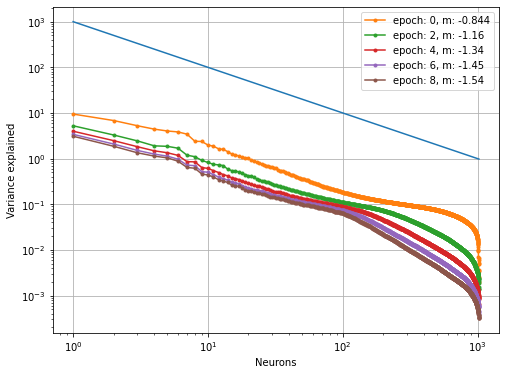

In [86]:
with open("data/neuron_firings/hid_1024.k_1.optim_sgd.pickle", "rb") as fp:
    data = pickle.load(fp)
nfs = data["neuron_fireings"]
import sklearn
from sklearn.decomposition import PCA
n_hid=1024

fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(n_hid) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for i, vv in enumerate(nfs):
    if i % 2 == 1:
        continue
    # vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {i}, m: {m:.3}")
plt.legend()
ax.grid()

In [6]:
import joblib
from tqdm import tqdm

param_list = [(784, n_hid, k, optim_method) for n_hid in [2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14, 2**15] for k in [1,2,3,4,5] for optim_method in ["sgd", "adam"]]
param_list

[(784, 256, 1, 'sgd'),
 (784, 256, 1, 'adam'),
 (784, 256, 2, 'sgd'),
 (784, 256, 2, 'adam'),
 (784, 256, 3, 'sgd'),
 (784, 256, 3, 'adam'),
 (784, 256, 4, 'sgd'),
 (784, 256, 4, 'adam'),
 (784, 256, 5, 'sgd'),
 (784, 256, 5, 'adam'),
 (784, 512, 1, 'sgd'),
 (784, 512, 1, 'adam'),
 (784, 512, 2, 'sgd'),
 (784, 512, 2, 'adam'),
 (784, 512, 3, 'sgd'),
 (784, 512, 3, 'adam'),
 (784, 512, 4, 'sgd'),
 (784, 512, 4, 'adam'),
 (784, 512, 5, 'sgd'),
 (784, 512, 5, 'adam'),
 (784, 1024, 1, 'sgd'),
 (784, 1024, 1, 'adam'),
 (784, 1024, 2, 'sgd'),
 (784, 1024, 2, 'adam'),
 (784, 1024, 3, 'sgd'),
 (784, 1024, 3, 'adam'),
 (784, 1024, 4, 'sgd'),
 (784, 1024, 4, 'adam'),
 (784, 1024, 5, 'sgd'),
 (784, 1024, 5, 'adam'),
 (784, 2048, 1, 'sgd'),
 (784, 2048, 1, 'adam'),
 (784, 2048, 2, 'sgd'),
 (784, 2048, 2, 'adam'),
 (784, 2048, 3, 'sgd'),
 (784, 2048, 3, 'adam'),
 (784, 2048, 4, 'sgd'),
 (784, 2048, 4, 'adam'),
 (784, 2048, 5, 'sgd'),
 (784, 2048, 5, 'adam'),
 (784, 4096, 1, 'sgd'),
 (784, 4096, 1, 

In [98]:
pip install pathos

     |████████████████████████████████| 81 kB 6.1 MB/s eta 0:00:011
     |████████████████████████████████| 65 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 53.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/shinzato/.venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
#from pathos.multiprocessing import ProcessingPool
from multiprocessing import Pool

pool = Pool(processes=36)
with tqdm(total=len(param_list)) as t:
    for _ in pool.imap_unordered(experiment, param_list):
        t.update()

  0%|                                                                      | 0/80 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [16]:
for param in tqdm(param_list[50:]):
    experiment(param)

 33%|██████████████████▋                                     | 10/30 [2:02:25<4:04:50, 734.54s/it]


MemoryError: 